In [1]:
#pip install h5py nibabel pandas glob2 regex
import numpy as np
import matplotlib.pyplot as plt
import h5py
import nibabel as nib
import scipy.io
import time
import pandas as pd
import glob
import re
import os
import sys

from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product

import torch
import torch.nn as nn

In [2]:
! ls /workspace/walinet/PaulTrainData/

3DMRSIMAP_Vol_04_A_1_2024-09-06_L2_0p0005
3DMRSIMAP_Vol_05_A_1_2024-09-02_L2_0p0005
3DMRSIMAP_Vol_06_A_1_2024-08-22_L2_0p0005
3DMRSIMAP_Vol_08_A_1_2024-09-07_L2_0p0005
3DMRSIMAP_Vol_09_A_1_2024-09-03_L2_0p0005
3DMRSIMAP_Vol_10_A_1_2024-09-04_L2_0p0005
3DMRSIMAP_Vol_16_A_1_2024-09-05_L2_0p0005


In [3]:
# path
p = '/workspace/walinet/PaulTrainData/3DMRSIMAP_Vol_05_A_1_2024-09-02_L2_0p0005/TESTING_beforeLipid.mat'
p_wat = '/workspace/walinet/PaulTrainData/3DMRSIMAP_Vol_05_A_1_2024-09-02_L2_0p0005/WaterReference.mat'
#p_train = '/workspace/walinet/PaulTrainData/3DMRSIMAP_Vol_06_A_1_2024-08-22_L2_0p0005/TrainData/TrainData_v3.h5'

# Water Removal
b_RemWat = True
WatSuppComp = 32 # Number of component for the HSVD water removal (advised: 16 at 3T and 32 at 7T)
minFreq = -150 # -150Hz(7T) # +-0.5ppm
maxFreq = 150 # 150
parallel_jobs = 20

bandwidth = 3000 # 3khz
dwell_time = 1/bandwidth

In [5]:
zdim=20
fh = h5py.File(p,'r')
csi_crrt = np.array(fh['csi'][:,20,:,:,:])
#csi_crrt = np.array(fh['csi_crrt_sl20'])
csi_crrt = csi_crrt['real']+1j*csi_crrt['imag']
csi_crrt = np.transpose(csi_crrt, axes=(3,2,1,0)) # (32, 64, 64, 960) (coils, xdim, ydim, time)

mask = np.array(fh['mask'])
mask = np.transpose(mask, axes=(2,1,0))
headmask = np.ones((64,64,39))


fh_wat = scipy.io.loadmat(p_wat)
weights = fh_wat['weights'][:,:,:,zdim]  # (32, 64, 64, 39) (coils, xdim, ydim, slices)

In [6]:
############################
##### Coil Combination #####
############################

csi_rrt = np.sum(csi_crrt * weights[:,:,:,None], axis=0)

In [7]:
###########################
##### Mask Generation #####
###########################


### Brainmask ###
brainmask = mask[:,:,zdim]



### Headmask ###
nuisance_rr = np.sum(np.abs(csi_rrt), axis=-1)

x, y = np.indices((64, 64))
circ = (x-32)**2+(y-32)**2
thresh = 1000
circ[circ<=thresh]=1
circ[circ>thresh]=0

headmask = circ*nuisance_rr

thresh2 = 9*10**11
headmask[headmask<thresh2] = 0
headmask[headmask>=thresh2] = 1

pad=10
ite=8
sl = zdim
tmp = headmask
tmp = np.pad(tmp, [(pad, pad), (pad, pad)])
tmp = scipy.ndimage.binary_dilation(tmp, iterations=ite)
tmp = scipy.ndimage.binary_erosion(tmp, iterations=ite)
headmask += tmp[pad:-pad,pad:-pad]
headmask[headmask>=1]=1



skmask = headmask - brainmask


In [8]:
#########################
##### Water Removal #####
#########################

def HSVD(y, fs, k):
    N = len(y)
    L = int(np.floor(0.5*N))

    # Hankel Matric and SVD
    H = scipy.linalg.hankel(y[:L], y[L:N])
    u, s, vh = np.linalg.svd(H)

    # Compute Z prime
    Uk = u[:,:k]
    Ukt = Uk[1:,:]
    Ukb = Uk[:-1,:]
    Zp = np.matmul(np.linalg.pinv(Ukb),Ukt)

    # Compute poles
    w, v = np.linalg.eig(Zp)
    Z = np.matmul(np.matmul(np.linalg.inv(v), Zp), v)
    q = np.log(np.diag(Z))
    dt = 1/fs
    dampings = np.real(q)/dt
    dampings[dampings>10] = 10
    frequencies = np.imag(q)/(2*np.pi)/dt

    # Construct Basis
    t = np.arange(start=0,stop=len(y)*dt,step=dt)
    basis = np.exp(np.matmul(t[:,None], (dampings+2*np.pi*1j*frequencies)[None,:]))

    # Compute the amplitude estimates
    amps = np.matmul(np.linalg.pinv(basis),y)
    return frequencies, dampings, basis, amps

if b_RemWat:
    print("####### Water Suppression #######")
    sta_time = time.time()

    image_grid = np.array(csi_rrt)
    s = image_grid.shape
    image_rrt = np.zeros(image_grid.shape, dtype=np.complex64)
    water_rrt = np.zeros(image_grid.shape, dtype=np.complex64)


    def WaterSuppressionWrapper(image_rrt, mask, fs, k, minFreq, maxFreq):
        global WaterSuppression
        def WaterSuppression(tup):
            (x,y)=tup
            fid = image_rrt[x,y,:] 
            if mask[x,y]:
                #sta_time = time.time()
                frequencies, dampings, basis, amps = HSVD(y = fid,
                                                        fs = fs,
                                                        k = k)
                indx = np.where(np.logical_and(frequencies >= minFreq, maxFreq >= frequencies))[0]
                filtFid = fid - np.sum(np.matmul(basis[:,indx], np.diag(amps[indx])), 1)

                return (filtFid, x,y, np.sum(np.matmul(basis[:,indx], np.diag(amps[indx])), 1))
        return WaterSuppression

    WaterSuppression = WaterSuppressionWrapper(image_rrt = image_grid, 
                                                mask = headmask,
                                                fs = 1/dwell_time, 
                                                k = WatSuppComp, 
                                                minFreq = minFreq, 
                                                maxFreq = maxFreq)

   
    res = Parallel(n_jobs=parallel_jobs)(delayed(WaterSuppression)(tup=tup)
                        for tup in tqdm(product(range(s[0]), range(s[1])), total=s[0]*s[1], position=0, leave=True))

    for tup in res:
        if tup is not None:
            filtFid, x, y, waterFid= tup
            image_rrt[x,y] = filtFid
            water_rrt[x,y] = waterFid

    sto_time = time.time()
    print('Water Removal: ', sto_time-sta_time)

####### Water Suppression #######


100%|███████████████████████████████████████████████████████████████████████████| 4096/4096 [00:33<00:00, 121.32it/s]


Water Removal:  34.13219738006592


In [ ]:
#image_rrt = csi_rrt

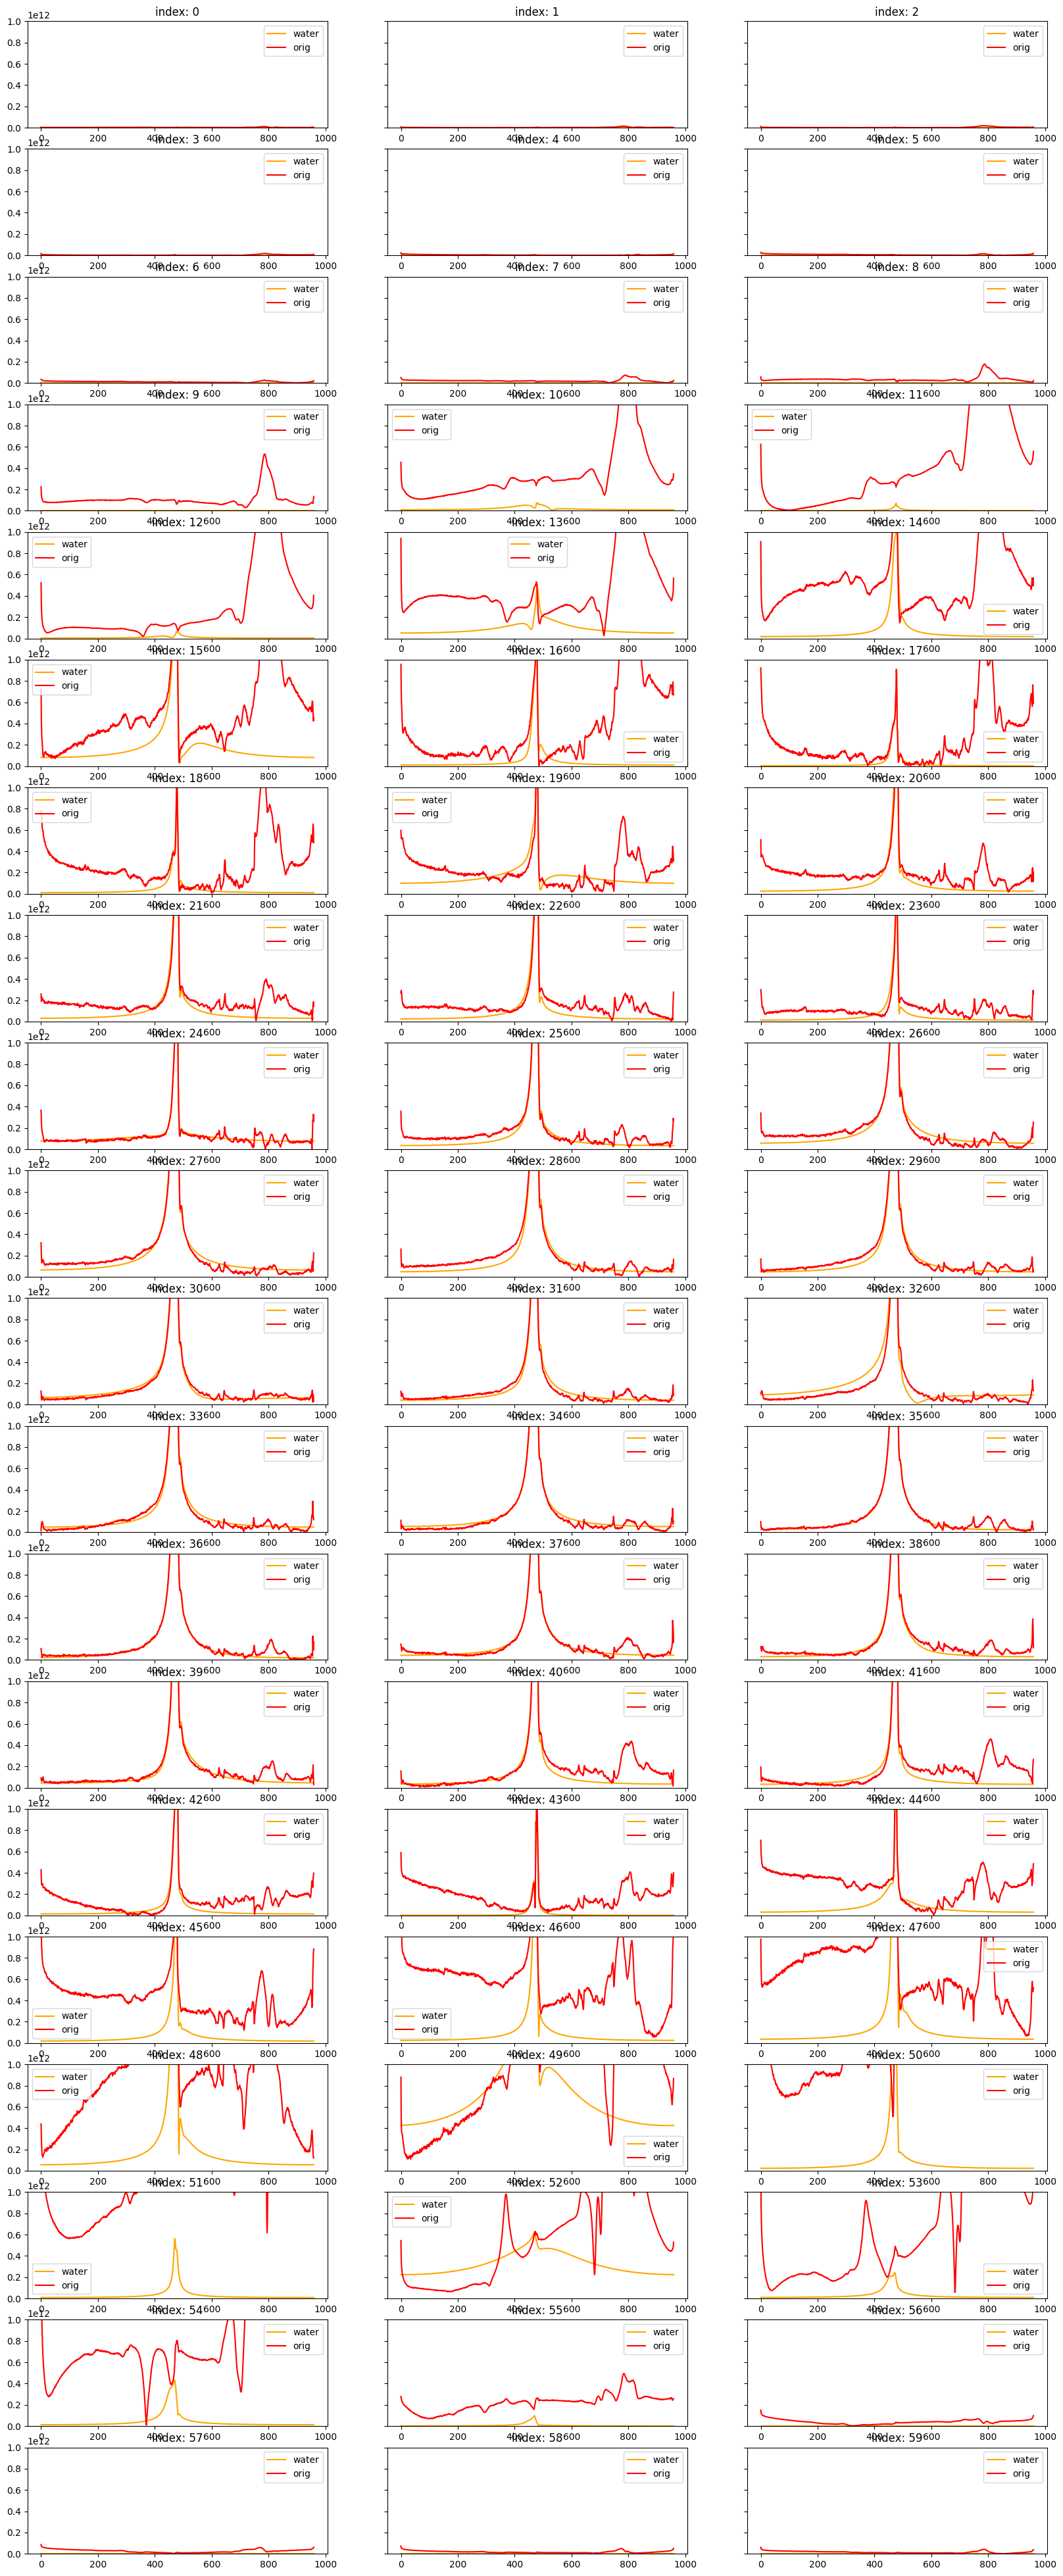

In [9]:
ydim=40#25

fig, ax = plt.subplots(nrows=20, ncols=3, figsize=(20,50), sharey=True)
for i in range(20):
    for ii in range(3):
        sl = i*3 + ii

        #ax2 = ax[i,ii].twinx()
        #fid2 = image_rrt[sl,ydim,:]
        #spec2 = np.fft.fftshift(np.fft.fft(fid2))
        #ax2.plot(np.abs(spec2), label='lipid+metab', color='green')
        #spec4 = Data_Lipid_rrf[sl,ydim,:]
        #ax2.plot(np.abs(spec4), label='pred', color='blue')
        #ax2.set_ylim([0,3*10**11])


        fid1 = water_rrt[sl,ydim,:]
        spec1 = np.fft.ifftshift(np.fft.fft(fid1))
        ax[i,ii].plot(np.abs(spec1), label='water', color='orange')
        fid3 = csi_rrt[sl,ydim,:]
        spec3 = np.fft.ifftshift(np.fft.fft(fid3))
        ax[i,ii].plot(np.abs(spec3), label='orig', color='red')
        ax[i,ii].set_ylim([0,1*10**12])
        ax[i,ii].legend()
        ax[i,ii].title.set_text('index: ' + str(sl))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
#plt.savefig("images/Subject"+sub+"_"+exp+"_lipidrem")
plt.show()

In [10]:
def runNNLipRemoval2(image_rrf, headmask, skMask, device, exp):
    sta_epoch = time.time()

    #################################
    ### Lipid Projection Operator ###
    #################################

    s = image_rrf.shape
    beta=1E-29 * 3 #beta=1E-24 * 3 #0.938
    multBeta = 1.5
    lipidFac = 0
    LipidTarget = 0.995 # 0.938
    lower=None
    

    Data_rf = np.reshape(image_rrf, (s[0]*s[1],s[2]))
    lipid_mask = np.reshape(skMask, (s[0]*s[1]))

    lipid_rf = Data_rf[lipid_mask>0,:]

    while np.abs(lipidFac-LipidTarget) > 0.005:
        LipidRem_Operator_ff = np.linalg.inv(np.eye(s[-1]) + beta * np.matmul(np.conj(lipid_rf).T, lipid_rf))
        ## Mean vlaue of diagonal should be 1 or above 0.9
        ## 
        #print("Mean Absolute Value of Diagonal of Lipid Suppression Operator: ")
        lipidFac = np.mean(np.abs(np.diagonal(LipidRem_Operator_ff)))
        print(lipidFac)

        if lipidFac < LipidTarget:
            beta = beta/multBeta
            if lower==False:
                multBeta=0.5*multBeta
            lower=True
        else:
            beta = beta*multBeta
            if lower==True:
                multBeta=0.5*multBeta
            lower=False

    LipidRem_Operator_ff = np.linalg.inv(np.eye(s[-1]) + beta * np.matmul(np.conj(lipid_rf).T, lipid_rf))
    LipidProj_Operator_ff = np.eye(s[-1])-LipidRem_Operator_ff
    #Data_ConvLipidRemoved_rrrf = np.reshape(np.matmul(Data_rf, LipidRem_Operator_ff), s)
    #Data_LipidProj_rrrf = np.reshape(np.matmul(Data_rf, LipidProj_Operator_ff), s)
    
    

    ####################
    ### Prepare Data ###
    ####################

    lip = image_rrf[headmask>0,:]
    lipProj = np.matmul(lip, LipidProj_Operator_ff)
    lip = torch.tensor(lip, dtype=torch.cfloat)
    lipProj = torch.tensor(lipProj, dtype=torch.cfloat)
    
    #####################
    ### Prepare Model ###
    #####################


    for f in os.listdir('/workspace/walinet/models/'+exp):
        if f.startswith("src"):
            sys.path.insert(0, '/workspace/walinet/models/'+exp+'/')
            sys.path.insert(0, '/workspace/walinet/models/'+exp+'/'+f)
            
            from config import params
            from src.initialize import initialize_model_folder, my_copy
            from src.training import training, validation
            from src.model import yModel
            break

      
    model = yModel(nLayers=params["nLayers"], 
                    nFilters=params["nFilters"], 
                    dropout=0,
                    in_channels=params["in_channels"], 
                    out_channels=params["out_channels"]
                    )
    

    params["path_to_model"] = "/workspace/walinet/models/"+exp+"/"
    model.load_state_dict(torch.load(params["path_to_model"] + 'model_last.pt'))
    #model.load_state_dict(torch.load(params["path_to_model"] + 'model_best.pt'))
    model.to(device)


    #####################
    ### Remove Lipids ###
    #####################

    Data_LipidRemoved_rf, Data_Lipid_rf = runModelOnLipData(lip=lip, 
                                            lipProj=lipProj, 
                                            model=model,
                                            device=device)

    Data_LipidRemoved_rrf = np.zeros(image_rrf.shape, dtype=np.cfloat)
    Data_LipidRemoved_rrf[headmask>0,:] = Data_LipidRemoved_rf.numpy()

    Data_Lipid_rrf = np.zeros(image_rrf.shape, dtype=np.cfloat)
    Data_Lipid_rrf[headmask>0,:] = Data_Lipid_rf.numpy()

    return Data_LipidRemoved_rrf, Data_Lipid_rrf


def runModelOnLipData(lip, lipProj, model, device):
    
    #spectra_energy = torch.amax(torch.abs(lip), dim=1)[:,None]
    #spectra_energy = torch.sqrt(torch.sum(torch.abs(torch.tensor(metab_rf))**2, dim=1))[:,None]
    spectra_energy = torch.sqrt(torch.sum(torch.abs(lip-lipProj)**2, dim=1))[:,None]
    #spectra_energy = torch.sqrt(torch.sum(torch.abs(lip[:,200:320]-lipProj[:,200:320])**2, dim=1))[:,None]
    lip /= spectra_energy
    lip = torch.stack((torch.real(lip), torch.imag(lip)), axis=1)
    lipProj /= spectra_energy
    lipProj = torch.stack((torch.real(lipProj), torch.imag(lipProj)), axis=1)

    prediction = torch.zeros(lip.shape, dtype=torch.cfloat)
    datasz = lipProj.shape[0]
    batchsz = 200
    
    loss_func = nn.MSELoss()
    model.eval()
    with torch.no_grad():
        for i in range(int(datasz/batchsz)+1):
            log = 'Percent: {:.2f}%'
            percent = (i+1)/int(datasz/batchsz)*100
            print(log.format(percent), end='\r')
            lip_batch = lip[i*batchsz:(i+1)*batchsz,:,:]
            lipProj_batch = lipProj[i*batchsz:(i+1)*batchsz,:,:]
            
            lip_batch, lipProj_batch = lip_batch.to(device), lipProj_batch.to(device)
            pred = model(lip_batch, lipProj_batch)[:,:2,:].cpu()
            prediction[i*batchsz:(i+1)*batchsz,:] = pred
    
    
    #loss = loss_func(prediction, true)
    #print('Pred loss: ', loss.item())
    #loss = loss_func(lip, true)
    #print('Inp loss: ', loss.item())
    prediction = prediction[:,0] + 1j*prediction[:,1]
    prediction = prediction*spectra_energy
    lip = lip[:,0] + 1j*lip[:,1]
    lip = lip * spectra_energy
    Data_LipidRemoved_rf = lip - prediction
    
    return Data_LipidRemoved_rf, prediction




device=torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

exp='EXP_2'
#exp='test'

#image_watersupp_rrrt
#img_b0corrected_rrrt

Data_LipidRemoved_rrf, Data_Lipid_rrf = runNNLipRemoval2(np.fft.fftshift(np.fft.fft(image_rrt,axis=-1),axes=-1),
                                                            headmask=headmask, 
                                                            skMask=skmask, 
                                                            device=device,
                                                            exp=exp)

0.9959160728010088


26602052787342.25


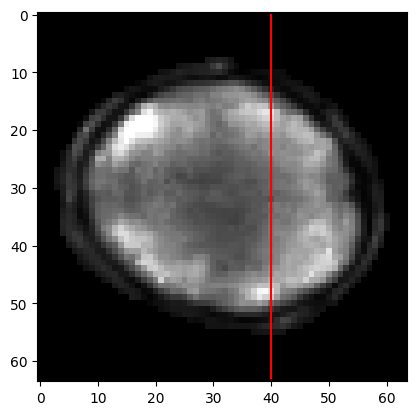

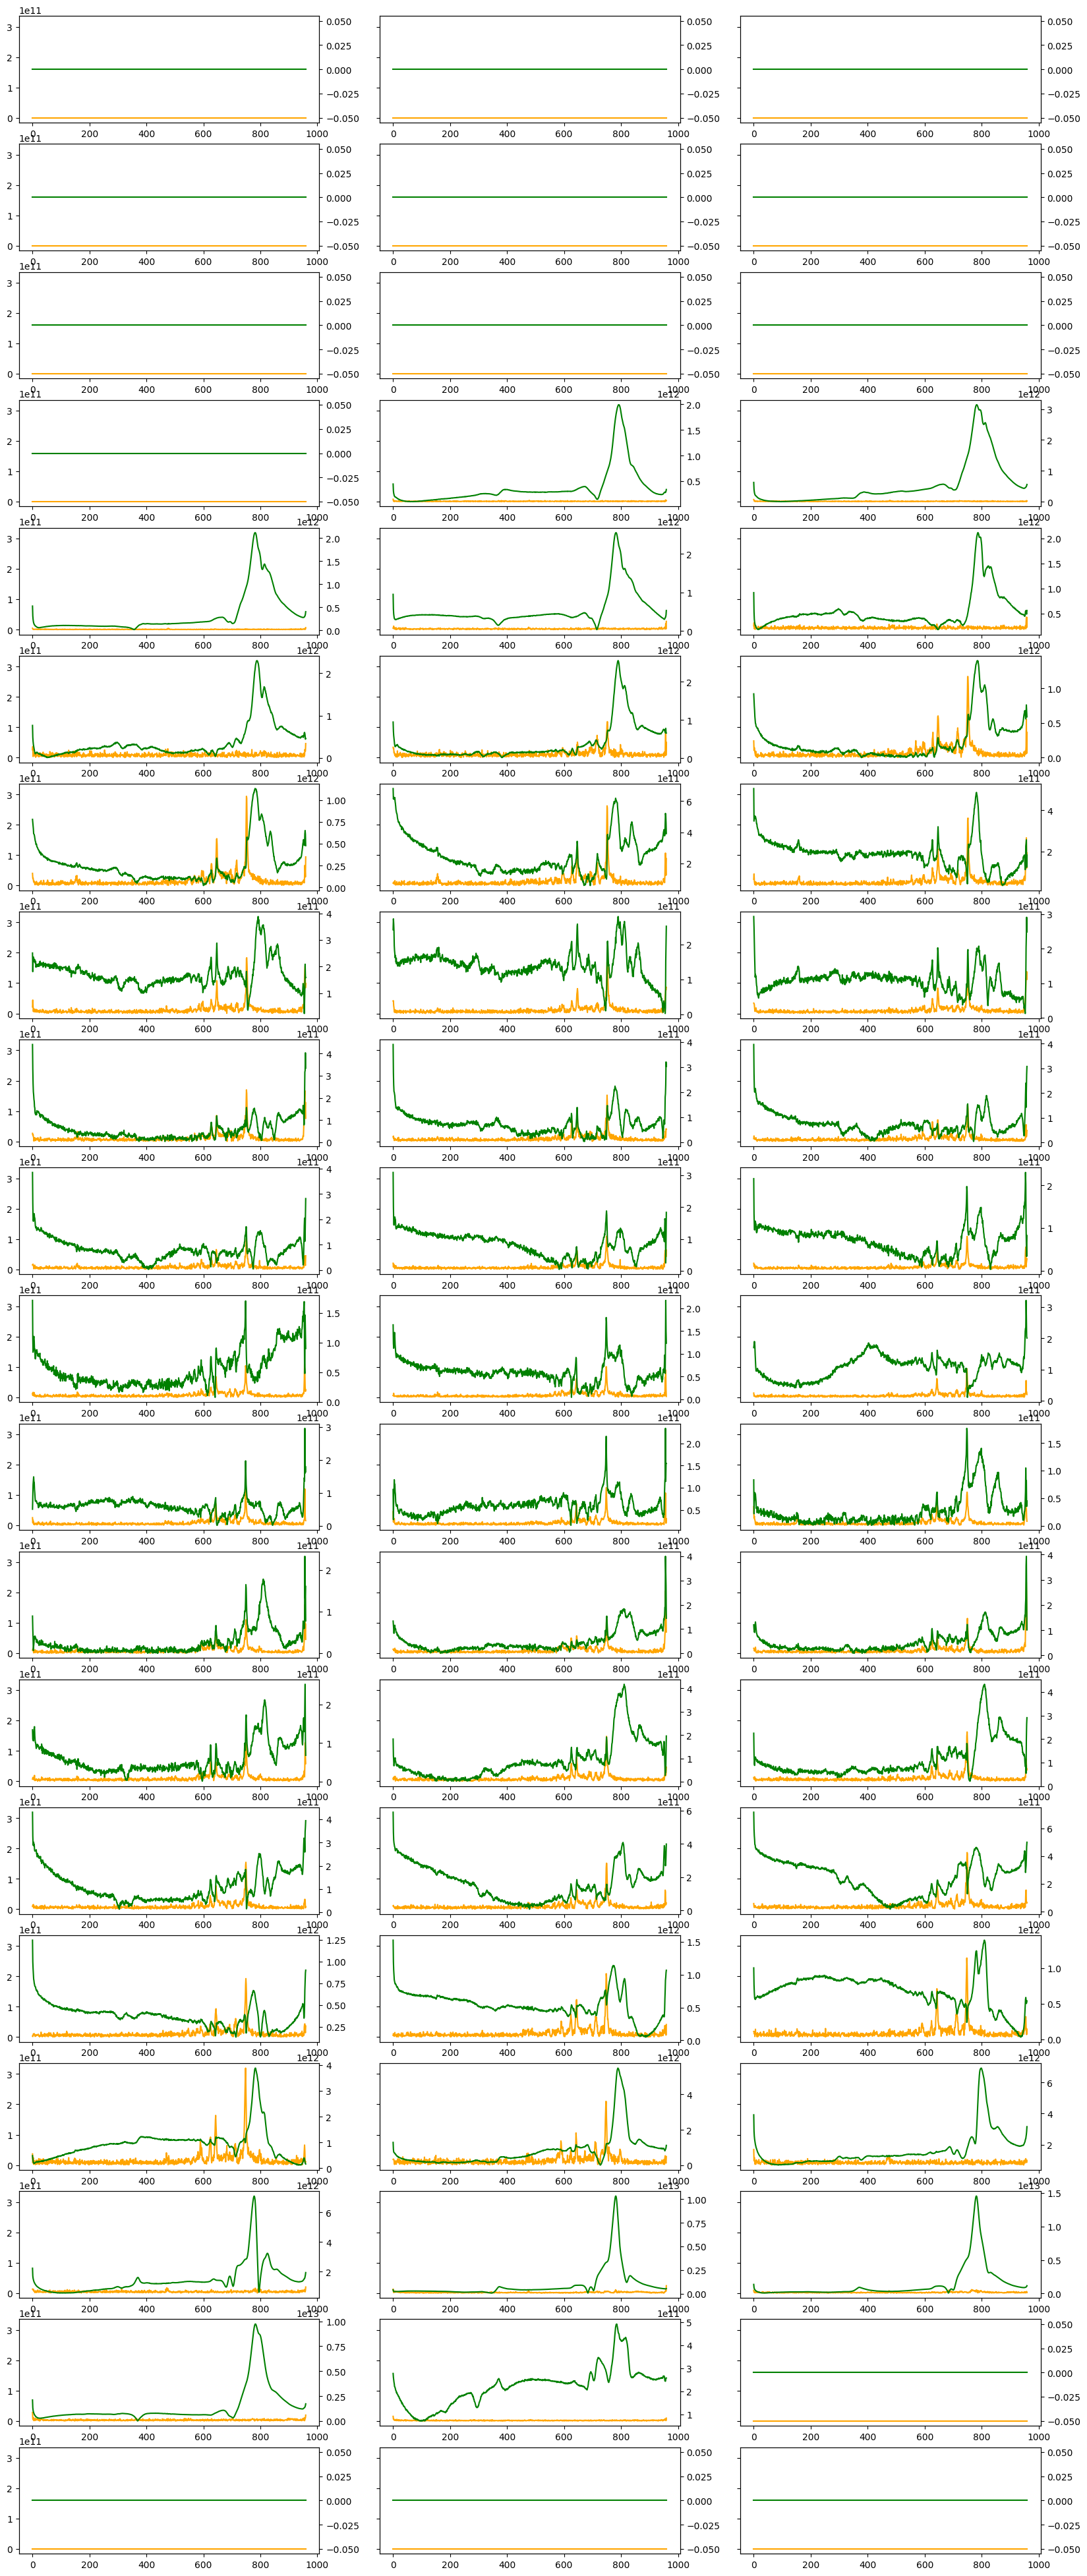

In [15]:
ydim=40#25

sum_img_grid = np.sum(np.abs(Data_LipidRemoved_rrf), axis=-1)


print(np.amax(sum_img_grid))
plt.imshow(sum_img_grid[:,:], cmap="gray", vmax=18994869145125)
x = [ydim, ydim]
y = [0,63]
plt.plot(x,y,'red')
plt.savefig("images/Subject_brain")
plt.show()


fig, ax = plt.subplots(nrows=20, ncols=3, figsize=(20,50), sharey=True)
for i in range(20):
    for ii in range(3):
        sl = i*3 + ii

        ax2 = ax[i,ii].twinx()
        fid2 = image_rrt[sl,ydim,:]
        spec2 = np.fft.fftshift(np.fft.fft(fid2))
        ax2.plot(np.abs(spec2), label='orig', color='green')
        #spec4 = Data_Lipid_rrf[sl,ydim,:]
        #ax2.plot(np.abs(spec4), label='pred', color='blue')
        #ax2.set_ylim([0,3*10**11])


        spec1 = Data_LipidRemoved_rrf[sl,ydim,:]
        ax[i,ii].plot(np.abs(spec1), label='pred', color='orange')
        #ax[i,ii].set_ylim([0,3*10**11])
        #ax[i,ii].legend()
        #ax[i,ii].title.set_text('index: ' + str(sl))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
plt.savefig("images/Subject_spectra")
plt.show()